In [1]:
#%pip install matplotlib pandas numpy

# Imports and Pre-Sets

In [2]:
import pandas as pd
import numpy as np
import random
import time
import matplotlib.pyplot as plt

# Set random seed for reproducibility
random.seed(42)

# Constants
NUM_TEAMS = 5
PLAYERS_PER_TEAM = 7
BUDGET_LIMIT = 750  # in million €


In [3]:
# import all custom classes
from CrossoverMethods import CrossoverMethods
from League import League
from GeneticAlgorithm import GeneticAlgorithm
from MutationMethods import MutationMethods
from Player import Player
from SelectionMethods import SelectionMethods
from SolutionAnalyzer import SolutionAnalyzer
from Team import Team

In [4]:
def load_data(filename='playersin.csv'):
    try:
        df = pd.read_csv('../Data/players(in).csv')
        print(f"Loaded {len(df)} players")
        return df
    except Exception as e:
        print(f"Error loading data: {e}")
        return None


# Apply Tests

In [5]:
 #Load player data
df = load_data('playersin.csv')  # Adjust filename if needed

# Create player objects
players = []
if df is not None:
    for i, row in df.iterrows():
        player = Player(
            id=i,
            name=row['Name'],
            position=row['Position'],
            skill=row['Skill'],
            salary=row['Salary (€M)']
        )
        players.append(player)

    # Count players by position
    positions = {'GK': 0, 'DEF': 0, 'MID': 0, 'FWD': 0}
    for player in players:
        positions[player.position] += 1
    
    print(f"Players by position: {positions}")
    required = {'GK': NUM_TEAMS, 'DEF': NUM_TEAMS*2, 'MID': NUM_TEAMS*2, 'FWD': NUM_TEAMS*2}
    
    # Check if we have enough players
    enough_players = True
    for pos, count in positions.items():
        if count < required[pos]:
            print(f"Not enough {pos} players! Need {required[pos]}, have {count}")
            enough_players = False
    
    if not enough_players:
        print("Warning: Not enough players for all positions!")



Loaded 35 players
Players by position: {'GK': 5, 'DEF': 10, 'MID': 10, 'FWD': 10}


In [6]:

if 'players' in locals() and players:
    # Set up genetic algorithm
    print("\nSetting up genetic algorithm...")
    ga = GeneticAlgorithm(
        players=players,
        pop_size=50,  # Population size
        generations=100  # Number of generations
    )
    # Run the algorithm
    best_league = ga.run()
else:
    print("Error: Players not loaded properly!")




Setting up genetic algorithm...
Starting genetic algorithm...
Initializing population...
Initial best fitness: 0.5222
Generation 0: Best fitness = 0.4371 (Time: 0.06s)
Generation 10: Best fitness = 0.1895 (Time: 0.37s)
Generation 20: Best fitness = 0.0571 (Time: 0.70s)
Generation 30: Best fitness = 0.0571 (Time: 1.03s)
Generation 40: Best fitness = 0.0571 (Time: 1.38s)
Generation 50: Best fitness = 0.0571 (Time: 1.72s)
Generation 60: Best fitness = 0.0571 (Time: 2.06s)
Generation 70: Best fitness = 0.0571 (Time: 2.42s)
Generation 80: Best fitness = 0.0571 (Time: 2.76s)
Generation 90: Best fitness = 0.0571 (Time: 3.10s)
Generation 99: Best fitness = 0.0571 (Time: 3.42s)
Evolution completed in 3.42 seconds
Final best fitness: 0.0571


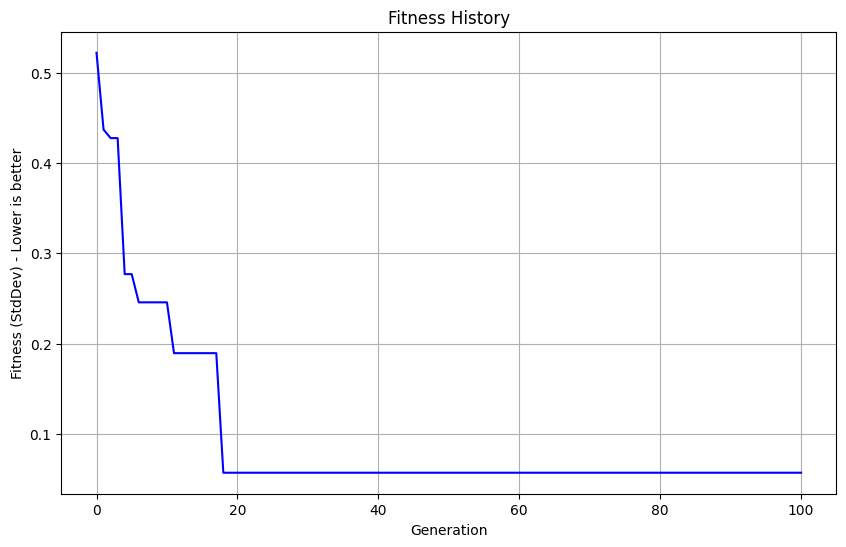


FANTASY LEAGUE SOLUTION ANALYSIS

League Standard Deviation: 0.0571
League Valid: True

TEAM DETAILS:

Team 1:
  Average Skill: 86.29
  Total Salary: 685M€ (Limit: 750M€)
  Valid Formation: True
  Within Budget: True
  Players:
    GK:
      - Alex Carter (Skill: 85, Salary: 90M€)
    DEF:
      - Lucas Bennett (Skill: 85, Salary: 90M€)
      - Brayden Hughes (Skill: 87, Salary: 100M€)
    MID:
      - Spencer Ward (Skill: 84, Salary: 85M€)
      - Bentley Rivera (Skill: 88, Salary: 100M€)
    FWD:
      - Sebastian Perry (Skill: 95, Salary: 150M€)
      - Tyler Jenkins (Skill: 80, Salary: 70M€)

Team 2:
  Average Skill: 86.43
  Total Salary: 685M€ (Limit: 750M€)
  Valid Formation: True
  Within Budget: True
  Players:
    GK:
      - Blake Henderson (Skill: 87, Salary: 95M€)
    DEF:
      - Ethan Howard (Skill: 80, Salary: 70M€)
      - Mason Reed (Skill: 82, Salary: 75M€)
    MID:
      - Dominic Bell (Skill: 86, Salary: 95M€)
      - Connor Hayes (Skill: 89, Salary: 105M€)
    FWD

In [7]:

if 'ga' in locals() and 'best_league' in locals():
    # Plot fitness history
    ga.plot_fitness_history()
    
    # Analyze and print the best solution
    SolutionAnalyzer.analyze_solution(best_league)
    
    # Export team details to CSV
    SolutionAnalyzer.export_solution_to_csv(best_league, 'league_solution.csv')
else:
    print("Error: Genetic algorithm not run successfully!")

# Fantasy Sports League Optimizer: A Detailed Explanation

This code implements a genetic algorithm to solve a fantasy sports league optimization problem. I'll explain the implementation in detail to prepare you for defending it, focusing on the algorithm design, implementation choices, and how each component works together.

## The Problem

The problem involves distributing football (soccer) players across teams to create a balanced league while maintaining certain constraints:

1. **Team Structure**: Each team must have exactly 1 goalkeeper (GK), 2 defenders (DEF), 2 midfielders (MID), and 2 forwards (FWD).
2. **Budget Constraint**: Each team has a salary cap of 750 million euros.
3. **Optimization Goal**: The main objective is to create balanced teams, where the average skill rating of players is roughly the same across all teams. This is measured by minimizing the standard deviation of the average skill ratings.

## Core Classes

### 1. Player Class

The Player class represents individual players with their attributes:

```python
class Player:
    def __init__(self, id, name, position, skill, salary):
        self.id = id
        self.name = name
        self.position = position  # GK, DEF, MID, or FWD
        self.skill = skill        # Player's skill rating
        self.salary = salary      # Player's salary in million euros
```

This class simply encapsulates player information and doesn't contain complex methods, following good object-oriented design principles by keeping the class focused on a single responsibility.

### 2. Team Class

The Team class represents a team in the league:

```python
class Team:
    def __init__(self, team_id):
        self.id = team_id
        self.players = []
        self.budget_limit = BUDGET_LIMIT  # 750 million euros
```

This class has several important methods:
- `add_player()`: Adds a player to the team
- `get_total_salary()`: Calculates the total salary of all players
- `get_avg_skill()`: Calculates the average skill rating of the team
- `is_within_budget()`: Checks if the team respects the budget constraint
- `has_valid_formation()`: Verifies that the team has the required formation (1 GK, 2 DEF, 2 MID, 2 FWD)

The `has_valid_formation()` method is crucial as it enforces one of the main constraints of the problem:

```python
def has_valid_formation(self):
    pos_count = {'GK': 0, 'DEF': 0, 'MID': 0, 'FWD': 0}
    for player in self.players:
        pos_count[player.position] = pos_count.get(player.position, 0) + 1
    
    return pos_count.get('GK', 0) == 1 and pos_count.get('DEF', 0) == 2 and \
           pos_count.get('MID', 0) == 2 and pos_count.get('FWD', 0) == 2
```

### 3. League Class

The League class represents a complete league configuration (a solution candidate):

```python
class League:
    def __init__(self, num_teams=NUM_TEAMS):
        self.teams = [Team(i) for i in range(num_teams)]
```

Key methods include:
- `get_avg_skills()`: Returns a list of average skill ratings for each team
- `get_skill_std_dev()`: Calculates the standard deviation of average skill ratings across teams
- `is_valid()`: Checks if the league configuration is valid (all teams have valid formations and stay within budget)

The `get_skill_std_dev()` method is particularly important as it computes the main optimization objective:

```python
def get_skill_std_dev(self):
    avg_skills = self.get_avg_skills()
    return np.std(avg_skills)
```

## The Genetic Algorithm Components

### 1. SelectionMethods Class

This class implements two selection methods for the genetic algorithm:

#### Tournament Selection
```python
@staticmethod
def tournament_selection(population, fitness_func, tournament_size=3):
    tournament = random.sample(population, tournament_size)
    return min(tournament, key=fitness_func)
```

Tournament selection works by:
1. Randomly selecting a subset of individuals (tournament_size = 3 by default)
2. Choosing the best individual from that subset based on fitness

This method provides selection pressure while still maintaining diversity in the population.

#### Roulette Wheel Selection
```python
@staticmethod
def roulette_wheel_selection(population, fitness_func):
    fitnesses = [fitness_func(individual) for individual in population]
    transformed_fitnesses = [1.0 / (f + 0.01) for f in fitnesses]
    total_fitness = sum(transformed_fitnesses)
    probabilities = [f / total_fitness for f in transformed_fitnesses]
    
    r = random.random()
    cumulative_prob = 0
    for i, prob in enumerate(probabilities):
        cumulative_prob += prob
        if r <= cumulative_prob:
            return population[i]
```

Roulette wheel selection:
1. Assigns selection probability proportional to fitness
2. Since this is a minimization problem (lower standard deviation is better), it transforms the fitness values using the reciprocal (1/fitness)
3. Selects individuals with probability proportional to their transformed fitness

### 2. CrossoverMethods Class

This class implements two crossover operators:

#### Team-based Crossover
```python
@staticmethod
def team_based_crossover(parent1, parent2, player_count):
    child = League()
    
    for i in range(NUM_TEAMS):
        if random.random() < 0.5:
            # Take team from parent1
            for player in parent1.teams[i].players:
                child.teams[i].add_player(player)
        else:
            # Take team from parent2
            for player in parent2.teams[i].players:
                child.teams[i].add_player(player)
    
    # Check if child is valid (no duplicate players)
    player_ids = set()
    for team in child.teams:
        for player in team.players:
            if player.id in player_ids:
                return None  # Invalid child
            player_ids.add(player.id)
    
    # Make sure we have all players assigned
    if len(player_ids) != player_count:
        return None
    
    return child
```

This crossover:
1. For each team position, randomly selects the entire team from either parent1 or parent2
2. Checks if the resulting child is valid (no duplicate players, all players assigned)
3. Returns None if the child is invalid, signaling that a new individual should be created

#### Position-based Crossover
```python
@staticmethod
def position_based_crossover(parent1, parent2, player_count):
    child = League()
    assigned_players = set()
    
    for position in ['GK', 'DEF', 'MID', 'FWD']:
        source_parent = parent1 if random.random() < 0.5 else parent2
        
        position_players = []
        for team in source_parent.teams:
            for player in team.players:
                if player.position == position:
                    position_players.append((team.id, player))
        
        for team_id, player in position_players:
            if player.id not in assigned_players:
                child.teams[team_id].add_player(player)
                assigned_players.add(player.id)
    
    # Validation checks
    valid_formation = True
    for team in child.teams:
        if not team.has_valid_formation():
            valid_formation = False
            break
    
    if not valid_formation or len(assigned_players) != player_count:
        return None
    
    return child
```

This crossover:
1. For each position type (GK, DEF, MID, FWD), randomly selects which parent to take all players of that position from
2. Checks if the resulting formation is valid and all players are assigned
3. Returns None if invalid

### 3. MutationMethods Class

This class implements three mutation operators:

#### Swap Mutation
```python
@staticmethod
def swap_mutation(league, mutation_rate=0.2):
    if random.random() > mutation_rate:
        return league  # No mutation
    
    # Deep copy the league
    mutated = League()
    for i, team in enumerate(league.teams):
        for player in team.players:
            mutated.teams[i].add_player(player)
    
    # Randomly select two teams and a position
    team_idx1 = random.randint(0, NUM_TEAMS - 1)
    team_idx2 = random.randint(0, NUM_TEAMS - 1)
    
    while team_idx1 == team_idx2:
        team_idx2 = random.randint(0, NUM_TEAMS - 1)
    
    pos = random.choice(['GK', 'DEF', 'MID', 'FWD'])
    
    # Get players of the selected position from both teams
    team1_players = [p for p in mutated.teams[team_idx1].players if p.position == pos]
    team2_players = [p for p in mutated.teams[team_idx2].players if p.position == pos]
    
    # If either team doesn't have players of this position, don't mutate
    if not team1_players or not team2_players:
        return league
    
    # Swap random players between teams
    player1 = random.choice(team1_players)
    player2 = random.choice(team2_players)
    
    mutated.teams[team_idx1].players.remove(player1)
    mutated.teams[team_idx2].players.remove(player2)
    
    mutated.teams[team_idx1].add_player(player2)
    mutated.teams[team_idx2].add_player(player1)
    
    return mutated
```

This mutation:
1. Has a 20% chance of applying (controlled by mutation_rate)
2. Selects two random teams and a random position
3. Swaps a random player of that position between the two teams

#### Position Shuffle Mutation
```python
@staticmethod
def position_shuffle_mutation(league, mutation_rate=0.15):
    # Similar structure to swap_mutation but shuffles all players of a position
```

This mutation:
1. Has a 15% chance of applying
2. Selects a random position (GK, DEF, MID, FWD)
3. Collects all players of that position across all teams, shuffles them, and reassigns them

#### Scramble Mutation
```python
@staticmethod
def scramble_mutation(league, mutation_rate=0.1):
    # More complex mutation that potentially swaps players with other teams
```

This mutation:
1. Has a 10% chance of applying
2. Selects a random team to scramble
3. For each position group, potentially swaps players with other teams

### 4. GeneticAlgorithm Class

This is the main class that coordinates the entire optimization process. Key methods include:

#### Creating Random Individuals
```python
def create_random_individual(self):
    league = League()
    
    # Shuffle players by position
    gks = self.players_by_pos['GK'].copy()
    defs = self.players_by_pos['DEF'].copy()
    mids = self.players_by_pos['MID'].copy()
    fwds = self.players_by_pos['FWD'].copy()
    
    random.shuffle(gks)
    random.shuffle(defs)
    random.shuffle(mids)
    random.shuffle(fwds)
    
    # Assign players to teams
    for i in range(NUM_TEAMS):
        # Add 1 GK per team
        if i < len(gks):
            league.teams[i].add_player(gks[i])
        
        # Add 2 DEF, 2 MID, 2 FWD per team
        for j in range(2):
            idx = i * 2 + j
            if idx < len(defs):
                league.teams[i].add_player(defs[idx])
            if idx < len(mids):
                league.teams[i].add_player(mids[idx])
            if idx < len(fwds):
                league.teams[i].add_player(fwds[idx])
    
    return league
```

This method:
1. Creates an empty league
2. Shuffles players of each position
3. Assigns them to teams according to the required formation

#### Fitness Function
```python
def fitness(self, league):
    # If the league is invalid, apply a penalty
    for team in league.teams:
        # Check formation
        if not team.has_valid_formation():
            return 1000.0
        
        # Check budget
        if team.get_total_salary() > BUDGET_LIMIT:
            return 500.0 + (team.get_total_salary() - BUDGET_LIMIT)
    
    # Calculate standard deviation of average skills
    std_dev = league.get_skill_std_dev()
    
    # Add a small penalty for teams close to the budget limit
    budget_penalty = 0
    for team in league.teams:
        if team.get_total_salary() > 0.95 * BUDGET_LIMIT:
            budget_penalty += 0.05
    
    return std_dev + budget_penalty
```

This fitness function:
1. Applies severe penalties for invalid formations (1000.0)
2. Applies penalties for exceeding the budget (500.0 + excess amount)
3. Uses the standard deviation of team skill ratings as the main component
4. Adds small penalties for teams close to the budget limit (to encourage more financially balanced solutions)

#### Main Optimization Loop
```python
def run(self):
    # Initialize population
    self.initialize_population()
    
    # Main evolution loop
    for generation in range(self.generations):
        # Create new population with elitism
        new_population = [self.best_solution]  # Keep the best
        
        # Create the rest through selection, crossover, mutation
        while len(new_population) < self.pop_size:
            # Selection - alternate between methods
            if len(new_population) % 2 == 0:
                parent1 = SelectionMethods.tournament_selection(self.population, self.fitness)
                parent2 = SelectionMethods.tournament_selection(self.population, self.fitness)
            else:
                parent1 = SelectionMethods.roulette_wheel_selection(self.population, self.fitness)
                parent2 = SelectionMethods.roulette_wheel_selection(self.population, self.fitness)
            
            # Crossover - alternate between methods
            offspring = None
            if random.random() < 0.5:
                offspring = CrossoverMethods.team_based_crossover(parent1, parent2, len(self.players))
            else:
                offspring = CrossoverMethods.position_based_crossover(parent1, parent2, len(self.players))
            
            # If invalid offspring, create random one
            if offspring is None:
                offspring = self.create_random_individual()
            
            # Mutation - randomly select an operator
            mutation_choice = random.random()
            if mutation_choice < 0.4:  # 40% chance
                offspring = MutationMethods.swap_mutation(offspring)
            elif mutation_choice < 0.7:  # 30% chance
                offspring = MutationMethods.position_shuffle_mutation(offspring)
            else:  # 30% chance
                offspring = MutationMethods.scramble_mutation(offspring)
            
            # Add to new population
            new_population.append(offspring)
        
        # Replace old population and update best solution
        self.population = new_population
        for individual in self.population:
            fitness = self.fitness(individual)
            if fitness < self.best_fitness:
                self.best_fitness = fitness
                self.best_solution = individual
        
        self.fitness_history.append(self.best_fitness)
    
    return self.best_solution
```

This method:
1. Initializes a random population
2. Runs for a specified number of generations
3. Uses elitism to keep the best solution
4. Creates the rest of the population through:
   - Selection: Alternating between tournament and roulette wheel selection
   - Crossover: Alternating between team-based and position-based crossover
   - Mutation: Applying one of three mutation operators with different probabilities
5. Updates the best solution found so far
6. Returns the best solution after completing all generations

## Analysis and Visualization

The code includes a `SolutionAnalyzer` class to evaluate and visualize the results:

```python
class SolutionAnalyzer:
    @staticmethod
    def analyze_solution(league):
        # Print detailed information about the solution
        
    @staticmethod
    def export_solution_to_csv(league, filename):
        # Export the league solution to a CSV file
```

The `GeneticAlgorithm` class also includes a `plot_fitness_history()` method that visualizes the improvement of the best solution over generations.

## Execution Flow

The code is organized to run in a Jupyter notebook with distinct execution steps:

1. **Setup**: Import libraries, define constants, and implement classes
2. **Data Loading**: Load player data from the CSV file
3. **Optimization**: Run the genetic algorithm
4. **Analysis**: Visualize results and analyze the solution

## Key Features to Highlight During Defense

1. **Constraint Handling**: The code effectively handles hard constraints (team formation, salary cap) through penalties in the fitness function.

2. **Fitness Function Design**: The fitness function combines multiple objectives:
   - Primary: Minimizing the standard deviation of team skill ratings
   - Secondary: Staying within budget constraints
   - Tertiary: Avoiding solutions too close to the budget limit

3. **Multiple Operators**: The code implements:
   - 2 selection methods (tournament and roulette wheel)
   - 2 crossover operators (team-based and position-based)
   - 3 mutation operators (swap, position shuffle, and scramble)

4. **Modular Design**: The code follows good object-oriented design principles with clear separation of concerns:
   - Data structures (Player, Team, League)
   - Genetic operators (Selection, Crossover, Mutation)
   - Analysis and visualization

5. **Elitism**: The algorithm preserves the best solution in each generation, ensuring that the solution quality never decreases.

6. **Error Handling**: The code checks for invalid offspring from crossover operations and replaces them with random individuals.

7. **Dynamic Operator Selection**: The algorithm dynamically alternates between different selection and crossover methods and applies different mutation operators with varying probabilities.

This approach aligns well with the genetic algorithm theory presented in the textbook by Leonardo Vanneschi and Sara Silva, particularly the concepts of selection pressure, genetic diversity, and constraint handling.